# Documenter Process

---

## 1. Set API Keys

In [20]:
import os
from config.secret_keys import OPENAI_API_KEY, TAVILY_API_KEY, POLYGON_API_KEY, USER_AGENT

os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY
os.environ['TAVILY_API_KEY'] = TAVILY_API_KEY
os.environ['POLYGON_API_KEY'] = POLYGON_API_KEY
os.environ['USER_AGENT'] = USER_AGENT

## 2. Import Modules

In [21]:
# Directory Setting
from pathlib import Path
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

# Define State
from typing_extensions import TypedDict
from typing import Annotated, List
# from langchain_core.messages import BaseMessage
# from langgraph.graph.message import add_messages
import operator

# Define Tool
import pandas as pd
from langchain.tools import tool, Tool
import yfinance as yf
from polygon import RESTClient
import requests
from langchain.agents.agent_types import AgentType
from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent
from tavily import TavilyClient
from langchain_openai import ChatOpenAI
from langchain_community.document_loaders import WebBaseLoader
from bs4 import BeautifulSoup
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_community.tools.tavily_search import TavilySearchResults

# Define Agent
from datetime import datetime
from langgraph.prebuilt import create_react_agent
# from pydantic import BaseModel, Field
# from langchain import hub
from langgraph.types import Send

# Define Node
# from langchain_core.documents import Document

## 3. Directory Setting / Construct VectorStore

In [22]:
BASE_DIR = Path(os.getcwd())
DATA_DIR = BASE_DIR / 'data'
CHART_DIR = BASE_DIR / 'chart'

In [23]:
urls = [
    'https://www.mk.co.kr/news/stock/11209083', # title : 돌아온 외국인에 코스피 모처럼 ‘활짝’…코스닥 700선 탈환
    'https://www.mk.co.kr/news/stock/11209254', # title : 힘 못받는 증시에 밸류업 ETF 두 달째 마이너스 수익률
    'https://www.mk.co.kr/news/stock/11209229', # title : 서학개미 한 달간 1조원 샀는데···테슬라 400달러 붕괴
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=300, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)

vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name = 'rag-chroma',
    embedding=OpenAIEmbeddings(),
)

retrieve = vectorstore.as_retriever()

## 4. Build Application

### 4-1. Define State

In [24]:
class State(TypedDict):
    user_query : str
    generation : str
    # documents : List[str]
    analyses : Annotated[List[dict], operator.add]

### 4-2. Define Tools

In [25]:
polygon_client = RESTClient(api_key=os.environ["POLYGON_API_KEY"])
tavily_client = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])
llm = ChatOpenAI(model='gpt-4o-mini', temperature=0)

#### 4-2-1. Stock Data Load

```python
fetch_stock_data.run({"ticker" : "NVDA",
                      "start_date" : "2023-01-01",
                      "end_date" : "2024-01-01"})
```

In [26]:
@tool
def fetch_stock_data(ticker:str, start_date:str, end_date:str):
    """
    Use this tool when you need to fetch stock data and compare with competitors.

    Before fetch stock data, you need to know 'ticker' about company.

    When you need to know 'ticker' use 'fetch_ticker_name' tool, before use this tool.
    
    Args:
        ticker (str) : ticker name about company
        start_date (str) : start date about stock data
        end_date (str) : end date about stock data
    
    Returns:
        str : path message about saved file
    """

    stock = yf.download(
        ticker, 
        start=start_date, 
        end=end_date, 
        progress=False
    )
    
    df = pd.DataFrame(index = stock.index)
    df[f'{ticker}'] = stock['Close']

    related_companies = polygon_client.get_related_companies(ticker)
    competitors = [company.ticker for company in related_companies]

    for company in competitors:
        try : 
            comp_ticker = company.replace('.', '-') if '.' in company else company
            comp_data = yf.download(
                comp_ticker,
                start = start_date,
                end=end_date,
                progress=False
            )

            if not comp_data.empty:
                df[company] = comp_data['Close']
        except Exception as e:
            continue
    
    csv_path = DATA_DIR / "stock_data.csv"
    df.to_csv(csv_path)

    return f"Stockfile saved to {csv_path}"

#### 4-2-2. Financial Data Load

```python
get_financial_data.run({"ticker" : "NVDA", "num_years" : 2})
```

In [27]:
@tool
def fetch_financial_data(ticker: str, num_years: int):
    """
    Use this tool when you need to fetch financial data and compare with competitors.

    Before fetch financial data, you need to know 'ticker' about company.

    When you need to know 'ticker' use 'fetch_ticker_name' tool, before use this tool.
    
    Args:
        ticker (str) : ticker name about company
        num_years (str) : number of years
    
    Returns:
        str : path message about saved file
    """
    # Polygon REST API Client 설정
    client = polygon_client
    
    # 최근 n개년간 분기별 재무제표 데이터 수집
    financials = []
    for f in client.vx.list_stock_financials(ticker):
        if "Q" in f.fiscal_period and f.end_date >= f"{pd.Timestamp.now().year - num_years}-01-01":
            financials.append(f)
    
    # DataFrame 생성할 데이터 목록 초기화
    data = {
        # 기본 정보
        "Fiscal Year": [],
        "Fiscal Period": [],
        "End Date": [],
        
        # 손익계산서 항목
        "Revenues": [],
        "Cost of Revenue": [],
        "Gross Profit": [],
        "Operating Income": [],
        "Operating Expenses": [],
        "Basic EPS": [],
        
        # 재무상태표 항목
        "Total Assets": [],
        "Current Assets": [],
        "Fixed Assets": [],
        "Intangible Assets": [],
        "Other Current Assets": [],
        "Other Non-current Assets": [],
        "Total Liabilities": [],
        "Current Liabilities": [],
        "Non-current Liabilities": [],
        "Long Term Debt": [],
        "Total Equity": [],
        "Inventory": [],
        "Accounts Payable": [],
        "Other Current Liabilities": [],
        
        # 현금흐름표 항목
        "Net Cash Flow": [],
        "Financing Cash Flow": [],
        
        # 포괄손익 항목
        "Comprehensive Income": [],
        "Other Comprehensive Income": [],
        
        # 성장률
        "YoY Growth": [],
        "QoQ Growth": [],
        
        # 재무비율
        "Current Ratio": [],  # 유동비율
        "Debt to Equity Ratio": [],  # 부채비율
        "Gross Profit Margin": [],  # 매출총이익률
        "Operating Margin": [],  # 영업이익률
        "Asset Turnover": []  # 총자산회전율
    }
    
    # 각 재무제표 항목에서 지표들을 추출하여 DataFrame 구성
    for i, f in enumerate(financials):
        # 기본 정보
        data["Fiscal Year"].append(f.fiscal_year)
        data["Fiscal Period"].append(f.fiscal_period)
        data["End Date"].append(f.end_date)

        # 재무제표 데이터 접근
        bs = f.financials.balance_sheet
        is_ = f.financials.income_statement
        cf = f.financials.cash_flow_statement
        ci = f.financials.comprehensive_income

        # 손익계산서 데이터 추출
        revenue = getattr(is_.revenues, 'value', None) if hasattr(is_, 'revenues') else None
        data["Revenues"].append(revenue)
        data["Cost of Revenue"].append(getattr(is_.cost_of_revenue, 'value', None) if hasattr(is_, 'cost_of_revenue') else None)
        data["Gross Profit"].append(getattr(is_.gross_profit, 'value', None) if hasattr(is_, 'gross_profit') else None)
        data["Operating Expenses"].append(getattr(is_.operating_expenses, 'value', None) if hasattr(is_, 'operating_expenses') else None)
        data["Operating Income"].append(getattr(is_.operating_expenses, 'value', None) if hasattr(is_, 'operating_expenses') else None)
        data["Basic EPS"].append(getattr(is_.basic_earnings_per_share, 'value', None) if hasattr(is_, 'basic_earnings_per_share') else None)
        
        # 재무상태표 데이터 추출
        data["Total Assets"].append(bs['assets'].value if 'assets' in bs else None)
        data["Current Assets"].append(bs['current_assets'].value if 'current_assets' in bs else None)
        data["Fixed Assets"].append(bs['fixed_assets'].value if 'fixed_assets' in bs else None)
        data["Intangible Assets"].append(bs['intangible_assets'].value if 'intangible_assets' in bs else None)
        data["Other Current Assets"].append(bs['other_current_assets'].value if 'other_current_assets' in bs else None)
        data["Other Non-current Assets"].append(bs['other_noncurrent_assets'].value if 'other_noncurrent_assets' in bs else None)
        data["Total Liabilities"].append(bs['liabilities'].value if 'liabilities' in bs else None)
        data["Current Liabilities"].append(bs['current_liabilities'].value if 'current_liabilities' in bs else None)
        data["Non-current Liabilities"].append(bs['noncurrent_liabilities'].value if 'noncurrent_liabilities' in bs else None)
        data["Long Term Debt"].append(bs['long_term_debt'].value if 'long_term_debt' in bs else None)
        data["Total Equity"].append(bs['equity'].value if 'equity' in bs else None)
        data["Inventory"].append(bs['inventory'].value if 'inventory' in bs else None)
        data["Accounts Payable"].append(bs['accounts_payable'].value if 'accounts_payable' in bs else None)
        data["Other Current Liabilities"].append(bs['other_current_liabilities'].value if 'other_current_liabilities' in bs else None)
        
        # 현금흐름표 데이터 추출
        data["Net Cash Flow"].append(getattr(cf.net_cash_flow, 'value', None) if hasattr(cf, 'net_cash_flow') else None)
        data["Financing Cash Flow"].append(getattr(cf.net_cash_flow_from_financing_activities, 'value', None) 
                                        if hasattr(cf, 'net_cash_flow_from_financing_activities') else None)
        
        # 포괄손익 데이터 추출
        if hasattr(ci, 'comprehensive_income_loss'):
            comp_income = ci.comprehensive_income_loss.value
        else:
            comp_income = ci.comprehensive_income.value if hasattr(ci, 'comprehensive_income') else None
        data["Comprehensive Income"].append(comp_income)
        data["Other Comprehensive Income"].append(getattr(ci.other_comprehensive_income_loss, 'value', None) 
                                                if hasattr(ci, 'other_comprehensive_income_loss') else None)
        
        # YoY 성장률 계산 (전년 동기 대비)
        if i > 3 and data["Revenues"][i-4] is not None and revenue is not None:
            yoy_growth = ((revenue - data["Revenues"][i-4]) / data["Revenues"][i-4]) * 100
        else:
            yoy_growth = None
        data["YoY Growth"].append(yoy_growth)
        
        # QoQ 성장률 계산 (직전 분기 대비)
        if i > 0 and data["Revenues"][i-1] is not None and revenue is not None:
            qoq_growth = ((revenue - data["Revenues"][i-1]) / data["Revenues"][i-1]) * 100
        else:
            qoq_growth = None
        data["QoQ Growth"].append(qoq_growth)
        
        # 재무비율 계산
        current_assets = bs['current_assets'].value if 'current_assets' in bs else None
        current_liabilities = bs['current_liabilities'].value if 'current_liabilities' in bs else None
        total_liabilities = bs['liabilities'].value if 'liabilities' in bs else None
        total_equity = bs['equity'].value if 'equity' in bs else None
        total_assets = bs['assets'].value if 'assets' in bs else None
        gross_profit = getattr(is_.gross_profit, 'value', None) if hasattr(is_, 'gross_profit') else None
        operating_income = getattr(is_.operating_expenses, 'value', None) if hasattr(is_, 'operating_expenses') else None
        
        # 유동비율 계산
        current_ratio = (current_assets / current_liabilities * 100) if (current_assets and current_liabilities) else None
        data["Current Ratio"].append(current_ratio)
        
        # 부채비율 계산
        debt_equity_ratio = (total_liabilities / total_equity * 100) if (total_liabilities and total_equity) else None
        data["Debt to Equity Ratio"].append(debt_equity_ratio)
        
        # 매출총이익률 계산
        gross_margin = (gross_profit / revenue * 100) if (gross_profit and revenue) else None
        data["Gross Profit Margin"].append(gross_margin)
        
        # 영업이익률 계산
        operating_margin = (operating_income / revenue * 100) if (operating_income and revenue) else None
        data["Operating Margin"].append(operating_margin)
        
        # 총자산회전율 계산
        asset_turnover = (revenue / total_assets) if (revenue and total_assets) else None
        data["Asset Turnover"].append(asset_turnover)

    # DataFrame 생성 및 정렬
    df = pd.DataFrame(data)
    df.sort_values(by="End Date", ascending=False, inplace=True)
    
    # 한글 컬럼명으로 변경
    korean_columns = {
        "Fiscal Year": "회계연도",
        "Fiscal Period": "회계기간",
        "End Date": "기준일",
        "Revenues": "매출액",
        "Cost of Revenue": "매출원가",
        "Gross Profit": "매출총이익",
        "Operating Income": "영업이익",
        "Operating Expenses": "영업비용",
        "Basic EPS": "기본주당순이익",
        "Total Assets": "총자산",
        "Current Assets": "유동자산",
        "Fixed Assets": "고정자산",
        "Intangible Assets": "무형자산",
        "Other Current Assets": "기타유동자산",
        "Other Non-current Assets": "기타비유동자산",
        "Total Liabilities": "총부채",
        "Current Liabilities": "유동부채",
        "Non-current Liabilities": "비유동부채",
        "Long Term Debt": "장기부채",
        "Total Equity": "총자본",
        "Inventory": "재고자산",
        "Accounts Payable": "매입채무",
        "Other Current Liabilities": "기타유동부채",
        "Net Cash Flow": "순현금흐름",
        "Financing Cash Flow": "재무활동현금흐름",
        "Comprehensive Income": "포괄손익",
        "Other Comprehensive Income": "기타포괄손익",
        "YoY Growth": "전년동기대비성장률",
        "QoQ Growth": "전기대비성장률",
        "Current Ratio": "유동비율",
        "Debt to Equity Ratio": "부채비율",
        "Gross Profit Margin": "매출총이익률",
        "Operating Margin": "영업이익률",
        "Asset Turnover": "총자산회전율"
    }
    
    df.rename(columns=korean_columns, inplace=True)
    
    # CSV 파일로 저장
    csv_path = DATA_DIR / "finance_data.csv"
    df.to_csv(csv_path, encoding='utf-8-sig')  # utf-8-sig로 저장하여 한글 깨짐 방지
    return f"재무제표 데이터가 {csv_path}에 저장되었습니다."

#### 4-2-3. CSV Data Analize Tool

```python
analyze_data.run({"query" : "NVDA의 가격 추이에 대해 분석해줘"})
```

In [28]:
@tool
def analyze_csv_data(query : str):
    """
    저장된 주식 데이터와 재무 데이터를 pandas_agent로 분석하고 질문에 답변합니다.
    """

    custom_prefix = f"""
        You are very smart analyst can use given data.
        Please analyze the data in various perspective to fine valuable insight.
        You shoould always make the greatest output with accurate metrics and tables.
    """
    
    stock_csv_path = DATA_DIR / "stock_data.csv"
    finance_csv_path = DATA_DIR / "finance_data.csv"
    upload_data_path = DATA_DIR / "data.csv"
    
    df_list = []

    try : 
        stock_df = pd.read_csv(stock_csv_path)
        df_list.append(stock_df)

        custom_prefix = custom_prefix + f"\nstock_data path : {stock_csv_path}\n"
    except Exception as e:
        pass

    try :
        finance_df = pd.read_csv(finance_csv_path)
        df_list.append(finance_df)

        custom_prefix = custom_prefix + f"\nfinance_data path : {finance_csv_path}\n"
    except Exception as e:
        pass

    try :
        upload_df = pd.read_csv(upload_data_path)
        df_list.append(upload_df)

        custom_prefix = custom_prefix + f"\nuser uploaded data path : {upload_data_path}"
    except Exception as e:
        pass

    

    pandas_agent = create_pandas_dataframe_agent(
        ChatOpenAI(model="gpt-4o"),
        df_list,
        verbose=True,
        agent_type=AgentType.OPENAI_FUNCTIONS,
        allow_dangerous_code=True,
        prefix = custom_prefix # (옵션) prompt에 의도한 문장을 추가
    )

    result = pandas_agent.run(query)

    return result

#### 4-2-4. Chart Generate Tool

```python
chart_generator.run({"command" : "NVDA stock price chart"})
```

In [29]:
@tool
def chart_generator(command:str):
    """
    이 도구는 create_pandas_dataframe_agent를 사용하여 차트를 생성하고 차트를 /charts 폴더에 저장합니다.
    """

    custom_prefix = f"""
        Please make the chart and save in './charts' folder.
    """
    
    stock_csv_path = DATA_DIR / "stock_data.csv"
    finance_csv_path = DATA_DIR / "finance_data.csv"
    upload_data_path = DATA_DIR / "data.csv"
    
    df_list = []

    try : 
        stock_df = pd.read_csv(stock_csv_path)
        df_list.append(stock_df)

        custom_prefix = custom_prefix + f"\nstock_data path is '{stock_csv_path}'\n"
    except Exception as e:
        pass

    try :
        finance_df = pd.read_csv(finance_csv_path)
        df_list.append(finance_df)

        custom_prefix = custom_prefix + f"\nfinance_data path is '{finance_csv_path}'\n"
    except Exception as e:
        pass

    try :
        upload_df = pd.read_csv(upload_data_path)
        df_list.append(upload_df)

        custom_prefix = custom_prefix + f"\nuser uploaded data path is '{upload_data_path}'"
    except Exception as e:
        pass
    

    pandas_agent = create_pandas_dataframe_agent(
        ChatOpenAI(model="gpt-4o"),
        df_list,
        verbose=True,
        agent_type=AgentType.OPENAI_FUNCTIONS,
        allow_dangerous_code=True,
        prefix = custom_prefix # (옵션) prompt에 의도한 문장을 추가
    )

    result = pandas_agent.run(command)

    return result

#### 4-2-5. Company News Load

```python
collect_competitor_news.run({"ticker":"NVDA", "news_count":3})
```

In [30]:
@tool
def fetch_competitor_news(ticker, news_count):
    """주어진 티커 관련 회사들의 최신 증권 뉴스를 수집합니다.
    Args:
        ticker (str): The company ticker.
        news_count (int): number how many news will we collect. Basic Number is 10.
    Returns:
        Dict(List): 
        A Dict of Competitors' news, each containing recent news articles' description.

    Example:
        response = competitor_news("ticker":"AAPL", "news_count":10)
        response = {"MSFT": ["US stock....", "MS invests on...", ...]}
    """
    related_companies = polygon_client.get_related_companies(ticker)
    competitors = [i.ticker for i in related_companies]
    
    competitors_news = {}
    for c in competitors:
        api_key = os.environ["POLYGON_API_KEY"]
        api_url = f"https://api.polygon.io/v2/reference/news?ticker={c}&order=desc&limit={news_count}&sort=published_utc&apiKey={api_key}"
        result = requests.get(api_url).json()
        if 'results' in list(result.keys()):
            competitors_news[c] = [i['description'] for i in result['results']]
    return competitors_news

@tool
def fetch_company_news(company_name: str) -> str:
    """Collect recent news for the given company."""
    search_results = tavily_client.search(query=f"recent news about {company_name}", days=7)
    return f"Collected news and market data for {company_name}: \n{search_results}"

@tool
def fetch_market_news(sector: str) -> str:
    """Collect recent market data for the given company's sector."""
    search_results = tavily_client.search(query=f"{sector} industry news", days=7)
    return f"Collected news and market data for {sector}: {search_results}"

@tool
def fetch_webpages_scrape(urls: List[str]) -> str:
    """Scrape the provided web pages for detailed information."""
    loader = WebBaseLoader(urls)
    docs = loader.load()
    return "\n\n".join(
        [f'<Document name="{doc.metadata.get("title", "")}">\n{doc.page_content}\n</Document>'
         for doc in docs]
    )

web_search_tool = TavilySearchResults(k=3)

#### 4-2-6. Non-financial indicators Summary Tool

```python
get_latest_filing_content({"ticker":'NVDA'})
```

In [31]:
@tool
def fetch_latest_filing_content(ticker: str) -> dict:
    """주어진 티커에 대한 최신 10-K, 10-Q, 8-K 파일링을 수집하고 해당 파일링의 내용을 추출합니다."""
    headers = {'User-Agent': "your.email@example.com"}
    company_tickers_url = "https://www.sec.gov/files/company_tickers.json"
    response = requests.get(company_tickers_url, headers=headers)
    if response.status_code != 200:
        return f"Failed to retrieve company tickers."
    company_tickers = response.json()
    company_data = pd.DataFrame.from_dict(company_tickers, orient='index')
    company_data['cik_str'] = company_data['cik_str'].astype(str).str.zfill(10)
    ticker = ticker.upper()
    company_data.set_index('ticker', inplace=True)
    if ticker not in company_data.index:
        return f"Ticker {ticker} not found."
    
    cik = company_data.loc[ticker, 'cik_str']
    base_url = f"https://data.sec.gov/submissions/CIK{cik}.json"
    response = requests.get(base_url, headers=headers)
    if response.status_code != 200:
        return f"Failed to retrieve filings for CIK {cik}"
    data = response.json()
    filings = data.get('filings', {}).get('recent', {})
    forms = filings.get('form', [])
    dates = filings.get('filingDate', [])
    accession_numbers = filings.get('accessionNumber', [])
    document_urls = filings.get('primaryDocument', [])
    df = pd.DataFrame({
        'form': forms,
        'date': dates,
        'accession_number': accession_numbers,
        'document_url': document_urls
    })
    df_filtered = df[df['form'].isin(['10-K', '10-Q', '8-K'])]
    latest_filings = df_filtered.sort_values('date', ascending=False).drop_duplicates('form')
    results = {}
    for _, row in latest_filings.iterrows():
        form_type = row['form']
        date = row['date']
        accession_number = row['accession_number']
        document_url = row['document_url']
        filing_url = f"https://www.sec.gov/Archives/edgar/data/{int(cik)}/{accession_number.replace('-', '')}/{document_url}"
        response = requests.get(filing_url, headers=headers)
        if response.status_code != 200:
            results[form_type] = f"Failed to retrieve the filing from {filing_url}"
        else:
            soup = BeautifulSoup(response.content, 'html.parser')
            text_content = soup.get_text(separator='\n')
            results[form_type] = {
                'date': date,
                'url': filing_url,
                'content': text_content
            }
        # LCEL 체인 구성
    def summarize_filings(filings: dict) -> dict:
        prompt = ChatPromptTemplate.from_template(
            """다음은 {form_type} 파일링의 내용입니다. 주요 재무 지표, 중요한 사실들, 
            그리고 구체적인 세부 사항을 포함하여 요약해주세요. 
            최대한 풍부한 요약이 되게끔 해주세요.
            
            각 보고서 유형에 따라 다음과 같은 중요 정보들을 포함해야 합니다:
        
            10-K (연간 보고서):
            - 주요 재무 지표 (정확한 수치와 함께 매출, 순이익, EPS 등)
            - 사업 개요 및 주요 제품/서비스 (구체적인 제품명이나 서비스명 포함)
            - 주요 시장 및 고객 (가능한 경우 주요 고객사 이름 포함)
            - 경영진의 주요 변동 사항 (해당되는 경우 구체적인 이름과 직책 포함)
            - 중요한 위험 요인 (구체적인 예시와 함께)
            - 향후 전략 및 전망
            - 주요 소송 또는 규제 이슈 (구체적인 사건명이나 관련 기관명 포함)
        
            10-Q (분기 보고서):
            - 분기별 주요 재무 지표 (정확한 수치와 전년 동기 대비 변동률)
            - 주요 제품/서비스의 실적 (구체적인 제품명이나 서비스명과 함께)
            - 시장 동향 및 경쟁 상황 (가능한 경우 경쟁사 이름 포함)
            - 단기적인 위험 요소나 기회 (구체적인 예시와 함께)
            - 주요 운영 변경 사항 (해당되는 경우 구체적인 내용 포함)
        
            8-K (수시 보고서):
            - 보고 이벤트의 성격 (예: 경영진 변경, 인수합병, 중요 계약 체결 등)
            - 해당 이벤트의 주요 내용 (관련된 모든 당사자의 이름, 금액, 날짜 등 포함)
            - 회사에 미치는 잠재적 영향 (가능한 경우 구체적인 수치 예측 포함)
            - 관련된 중요 인물의 배경 (해당되는 경우)
        
            각 항목에 대해 가능한 한 구체적인 세부 사항 (이름, 숫자, 날짜 등)을 포함해주세요. 
            그러나 전체 요약은 간결해야 하며, 각 항목은 1-3문장으로 제한해주세요.
        
            파일링 내용:
            {text}
        
            요약:"""
        )
        chain = prompt | llm | StrOutputParser()

        # 배치 처리를 위한 입력 준비
        inputs = [
            {"text": filing_data['content'], "form_type": form_type}
            for form_type, filing_data in filings.items()
            if isinstance(filing_data, dict) and 'content' in filing_data
        ]

        summaries = chain.batch(inputs)

        return {
            form_type: summary
            for (form_type, filing_data), summary in zip(filings.items(), summaries)
            if isinstance(filing_data, dict) and 'content' in filing_data
        }

    # 파일링 수집 및 요약
    summaries = summarize_filings(results)

    return summaries

#### 4-2-7. Ticker Name Load Tool

In [32]:
@tool
def fetch_ticker_name(user_query: str) -> str:
    """search ticker name about company you need to know"""
    search_results = tavily_client.search(query=f"ticker name about company in : {user_query}", days=7)
    return f"ticker name in {user_query} : \n{search_results}"

### 4-3. Define Agent

#### 4-3-1. Analyst Agent Prompt / Setting

In [33]:
llm = ChatOpenAI(model="gpt-4o-mini")

today = datetime.today().date().strftime('%Y-%m-%d')

financial_prompt = f"""오늘은 {today}입니다. 
당신은 뛰어난 재무 분석가입니다. 아래 임무를 지키면서, 데이터를 분석하고, 차트를 생성 및 저장해야 합니다.
당신의 임무는:
1. 회사의 재무 성명서를 면밀히 분석하여 숨겨진 통찰력을 발견하는 것
2. 주요 재무 비율을 계산하고 그 의미를 명확히 해석하는 것
3. 수익, 수익성, 현금 흐름의 추세를 파악하고 그에 따른 전략을 제안하는 것
4. 회사의 재무 건강 상태와 지속 가능성을 종합적으로 평가하는 것
5. 산업 표준과 비교하여 경쟁력을 분석하는 것

당신의 추론을 항상 명확히 설명하고, 특정 지표로 결론을 뒷받침하세요.
분석을 철저히 하되, 객관성을 유지하는 것을 잊지 마세요."""

stock_prompt = f"""오늘은 {today}입니다. 
당신은 전문 주식 시장 분석가입니다. 아래 임무를 지키면서, 데이터를 분석하고, 차트를 생성 및 저장해야 합니다.
당신의 임무는:
1. 역사적 주식 가격 움직임을 분석하여 패턴을 식별하는 것
2. 기술 지표와 패턴을 평가하여 미래의 가격 변동을 예측하는 것
3. 시장 분위기와 모멘텀을 분석하여 투자 기회를 포착하는 것
4. 동료 기업과의 가치 평가 지표를 비교하여 상대적 가치를 판단하는 것
5. 주요 가격 동인과 촉매를 식별하여 투자 전략을 수립하는 것

분석을 지원하는 구체적인 데이터 포인트와 차트를 제공하세요.
기술적 및 근본적 요소를 모두 고려하여 평가하세요."""

market_prompt = f"""오늘은 {today}입니다. 
당신은 전문 시장 연구원입니다. 아래 임무를 지키기 위해 SEC 파일링을 탐색하고, 기업, 경쟁사, 시장에 대한 시장 조사를 수행해주세요.
당신의 임무는:
1. 회사의 경쟁 위치를 분석하여 강점과 약점을 파악하는 것
2. 시장 동향과 산업 역학을 평가하여 기회를 탐색하는 것
3. 주요 경쟁사와 그들의 전략을 분석하여 시장 내 위치를 이해하는 것
4. 시장 기회와 위협을 평가하여 리스크를 관리하는 것
5. 회사의 시장 점유율과 성장 가능성을 분석하여 미래 전략을 제안하는 것
6. 특정 회사에 관한 분석 내용이 아닐 경우 사용자가 원하는 주제에 대해 검색하여 분석하고 위의 1~5 임무를 수행하는 것

결론을 뒷받침하는 구체적인 예시와 데이터를 사용하세요.
현재 시장 조건과 미래 동향을 모두 고려하여 분석하세요."""

#### 4-3-2. Define ReAct Agent Tool

In [34]:
financial_agent = create_react_agent(
    llm, 
    [fetch_financial_data, analyze_csv_data, chart_generator, fetch_ticker_name], 
    state_modifier = financial_prompt
)
stock_agent = create_react_agent(
    llm, 
    [fetch_stock_data, analyze_csv_data, chart_generator, fetch_ticker_name], 
    state_modifier = stock_prompt
)
market_agent = create_react_agent(
    llm, 
    [fetch_latest_filing_content, fetch_company_news, fetch_competitor_news, fetch_market_news, fetch_webpages_scrape, fetch_ticker_name, web_search_tool],
    state_modifier = market_prompt
)

In [35]:
# 5. Map 함수: 각 분석가에게 작업 할당
def map_to_analysts(state: State):
    user_query = state["user_query"]
    return [
        Send("financial_analyst", {"user_query": user_query, "task": "financial"}),
        Send("stock_analyst", {"user_query": user_query, "task": "stock"}),
        Send("market_analyst", {"user_query": user_query, "task": "market"})
    ]

# 6. 각 분석가 노드 함수
def analyst_node(state: dict, agent, task_type: str):
    """각 분석가의 작업을 실행하고 결과를 구조화"""
    user_query = state["user_query"]
    result = agent.invoke({"user_query": user_query})
    
    return {
        "analyses": [{
            "type": task_type,
            "content": result["generation"].content,
            "timestamp": datetime.now().isoformat()
        }]
    }

# 7. Reduce 함수: 분석 결과 통합
def combine_analyses(state: State):
    analyses = state["analyses"]
    
    charts_directory = './charts'
    chart_images = [f"![Chart]({charts_directory}/{file})" for file in os.listdir(charts_directory) if file.endswith(('.png', '.jpg', '.jpeg'))]
    
    report_prompt = f"""
    당신은 매우 훌륭한 기업 분석 전문가입니다. 주어진 정보를 종합적으로 이해하고, 풍부한 설명을 통해 기업 분석 보고서를 작성합니다.
    포괄적인 기업 분석 보고서를 작성해주세요. (형식: 마크다운, 언어: 한국어)
    이 기업 분석 보고서는 가능한 많은 정보를 담아야하며, 다음을 종합하여 작성합니다:

    <이전 분석>

    {analyses}
    
    </이전 분석>

    <차트>
    주어진 차트는 다음과 같습니다.
    {chart_images}
    주어진 차트의 제목을 고려하여 아래 지침의 각 섹션에 적절하게 삽입하세요.
    </차트>

    <지침>
    보고서는 마크다운 형식으로 작성하며, 주어진 데이터와 조사 결과를 바탕으로 작성합니다.
    가능하다면 표나 그래프를 최대한 활용하세요.

    보고서에는 다음이 포함되어야 합니다:

    1. ## 요약
    - 분석 결과의 주요 발견 및 통찰력에 대한 간략한 개요를 제공합니다.

    2. ## 재무 분석
    - 수익, 순이익, 자산, 부채 및 자본과 같은 상세한 재무 지표를 포함합니다.
    - 지난 몇 년간의 추세 및 비교를 논의합니다.

    3. ## 주식 성과 분석
    - 가격 변화, 변동성 및 시장 지수와의 비교를 포함한 주식 성과 지표를 분석합니다.

    4. ## 시장 위치 분석
    - 회사의 시장 위치를 평가하고 시장 점유율 및 경쟁 환경을 포함합니다.
    - 시장에서 회사의 강점과 약점에 대한 통찰력을 제공합니다.

    5. ## 위험 및 기회
    - 회사가 직면한 주요 위험과 성장 기회를 식별합니다.
    - 분석을 지원하기 위해 정량적 데이터를 사용합니다.

    6. ## 권장 사항
    - 분석을 바탕으로 명확한 권장 사항을 제공합니다.
    - 관련 데이터와 통찰력으로 권장 사항을 정당화합니다.
    </지침>

    """
    
    combined_report = llm.invoke(report_prompt)
    
    return {
        "combined_report": combined_report
    }

In [36]:
from langgraph.graph import END, StateGraph, START
# 8. 그래프 구성
workflow = StateGraph(State)

# Map 노드 추가
workflow.add_node("financial_analyst", 
                 lambda x: analyst_node(x, financial_agent, "financial"))
workflow.add_node("stock_analyst", 
                 lambda x: analyst_node(x, stock_agent, "stock"))
workflow.add_node("market_analyst", 
                 lambda x: analyst_node(x, market_agent, "market"))

# Reduce 노드 추가
workflow.add_node("combine", combine_analyses)

# START에서 map_to_analysts로 가는 조건부 엣지 추가
workflow.add_conditional_edges(
    START,
    map_to_analysts,
    {
        "financial_analyst": "financial_analyst",
        "stock_analyst": "stock_analyst",
        "market_analyst": "market_analyst"
    }
)

# 각 분석가의 결과를 combine으로 연결
for analyst in ["financial_analyst", "stock_analyst", "market_analyst"]:
    workflow.add_edge(analyst, "combine")

workflow.add_edge("combine", END)
# 9. 그래프 컴파일
app = workflow.compile()

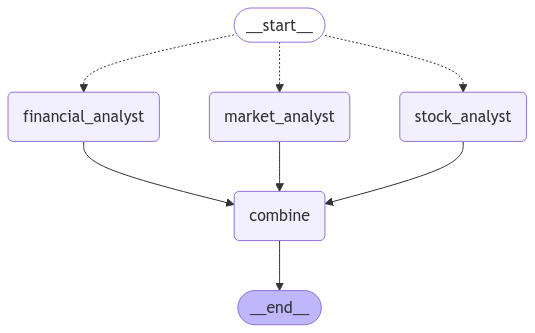

In [37]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [38]:
# 10. 실행 예시
config = {"recursion_limit": 50}
inputs = {
    "user_query": "테슬라에 대한 기업 분석 보고서를 작성해줄래?",
    "analyses": [],
    "combined_report": ""
}

for output in app.stream(inputs, config):
    if "__end__" not in output:
        print(output)
        print("---")

InvalidUpdateError: Must write to at least one of ['messages']